In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import pickle
from math import cos, pi

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data    
import spacy
import nltk
import itertools
import io
from imblearn.over_sampling import SMOTE
nlp = spacy.load('en')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device='cpu'
import read_preprocess
from models import DNN, dataset_csv
CUDA_LAUNCH_BLOCKING=1

from livelossplot import PlotLosses
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

Using TensorFlow backend.


In [2]:
class Discretize(BaseEstimator, TransformerMixin):
    def __init__(self, bucket_boundaries):
        self.bb = bucket_boundaries
        
    def fit(self,X:pd.DataFrame):
        self.X = X
        self.X_num = self.X.select_dtypes(exclude=['category','uint8'])
        self.cols = self.X_num.columns.tolist()
        return self
    def transform(self,X):
        df_disc = pd.DataFrame()
        for col in self.cols:
            df_disc[col] = pd.cut(self.X_num[col],bins = self.bb,labels=['young','middle_aged','old'])
        df_disc = pd.get_dummies(df_disc,drop_first=False)
        
        return pd.concat([self.X,df_disc],axis=1)

In [3]:
frame = pd.read_csv('./adv_train.csv', index_col=False)
target = "Rating"
frame['Rating'].value_counts()

1    13317
2     4300
3     3256
4     1910
5     1337
Name: Rating, dtype: int64

In [4]:
frame[target].values[frame[target].values>1]=2

In [5]:
def preprocess_sparse(frame_sparse):
    bad_na, good_na = [],[]
    for column in frame_sparse:
        if frame_sparse[column].isna().sum()/frame_sparse.shape[0] > 0.3:
            frame_sparse.append(column)
        elif frame_sparse[column].isna().sum()/frame_sparse.shape[0] <= 0.3 and frame_sparse[column].isna().any()==True:
            good_na.append(column)
        frame_sparse = frame_sparse.drop(bad_na,axis=1)
    print(f"Bad Frames: {len(bad_na)}")
    for col in good_na:
        frame_sparse[col] = frame_sparse[col].fillna(stats.stats.mode(frame_sparse[col])[0][0])
    return frame_sparse
frame = preprocess_sparse(frame)

Bad Frames: 0


In [6]:
glove_path = './glove.twitter.27B/glove.twitter.27B.25d.txt'
def load_glove(path):
    """
    creates a dictionary mapping words to vectors from a file in glove format.
    """
    with open(path) as f:
        glove = {}
        for line in f.readlines():
            values = line.split(' ')
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove[word] = vector
        return glove
    
def load_glove_embeddings(path, word2idx, embedding_dim=25):
    with open(path) as f:
        embeddings = np.zeros((len(word2idx), embedding_dim))
        for line in f.readlines():
            values = line.split(' ')
            word = values[0]
            index = word2idx.get(word)
            if index:
                vector = np.array(values[1:], dtype='float32')
                embeddings[index] = vector
        return torch.from_numpy(embeddings).float()

def tokenizer(text):
    text = text.replace('<br />',' ')
    text = text.replace('\x96',' ')
    text = nltk.word_tokenize(text)
    text = [w.lower() for w in text]
    return text

In [7]:
bucket_boundaries = [0, 24, 46, 100]
discretizer = Discretize(bucket_boundaries)
age = discretizer.fit_transform(frame[['Age']]).drop(['Age'],axis=1)
frame = frame.loc[:,'Rating':'unfav']
frame_sparse = frame.loc[:,'Rating':'Mostwatchedtvprogrammes_Weather']
frame_sparse = pd.concat((frame_sparse,age), axis=1)

frame_x_text = frame.loc[:,'fav':'unfav']

x_train_text = []
for i in frame_x_text['fav']+frame_x_text['unfav']:
    text = tokenizer(i)
    x_train_text.append(text)
    
# x_val_text = []
# for i in X_val_text_df['fav']+X_val_text_df['unfav']:
#     text = tokenizer(i)
#     x_val_text.append(text)
    
all_tokens = itertools.chain.from_iterable(x_train_text)
word_to_id = {token:idx for idx, token in enumerate(set(all_tokens))}

all_tokens = itertools.chain.from_iterable(x_train_text)
id_to_word = [token for idx, token in enumerate(set(all_tokens))]
id_to_word = np.asarray(id_to_word)

""" Load Train Embeddings """
glove = load_glove(glove_path)
train_embeddings = load_glove_embeddings(glove_path, word_to_id)

max_len = max([len(i) for i in x_train_text])
x_train_tokenized_sentences = np.array([[word_to_id[i] for i in j] for j in x_train_text])
# x_val_tokenized_sentences = np.array([[word_to_id[i] for i in j] for j in x_val_text])

# # Pad tokens with 0s
for i in range(len(x_train_tokenized_sentences)):
    a = x_train_tokenized_sentences[i]
    x_train_tokenized_sentences[i] = np.concatenate([a,np.zeros(max_len-len(a))])
    
# for i in range(len(x_val_tokenized_sentences)):
#     a = x_val_tokenized_sentences[i]
#     x_val_tokenized_sentences[i] = np.concatenate([a,np.zeros(max_len-len(a))])

<BarContainer object of 1 artists>

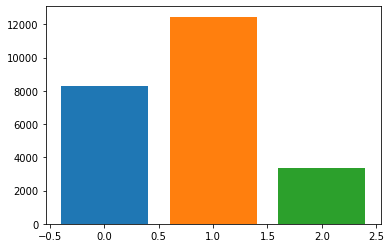

In [29]:
plt.bar([0],frame_sparse['Age_young'].value_counts()[1])
plt.bar([1],frame_sparse['Age_middle_aged'].value_counts()[1])
plt.bar([2],frame_sparse['Age_old'].value_counts()[1])

In [30]:
frame_x_embedded = pd.DataFrame(x_train_tokenized_sentences.tolist())
frame_x_embedded.columns = [str(i) for i in frame_x_embedded.columns]
combined_dataset = pd.concat((frame_sparse,frame_x_embedded), axis=1)

In [31]:
a = []
for i,j,k in zip(combined_dataset['Age_young'], combined_dataset['Age_middle_aged'], combined_dataset['Age_old']):
    if i==1: a.append(0)
    elif j==1: a.append(1)
    elif k==1: a.append(2)
age = pd.DataFrame(a,columns=["Age"])

combined_dataset["Age"] = age 

In [32]:
combined_dataset = combined_dataset.drop(['Age_young',"Age_middle_aged","Age_old"], axis=1)

In [33]:
# combined_dataset = pd.concat((frame_sparse,frame_x_embedded), axis=1)
# combined_x = combined_dataset.loc[:,combined_dataset.columns != target]
# combined_y = pd.DataFrame(combined_dataset[target],columns=[target])

combined_x_g = combined_dataset.loc[:,combined_dataset.columns != 'Age']
combined_y_g = pd.DataFrame(combined_dataset['Age'],columns=['Age'])
smote_oversample = SMOTE()
combined_x_g, combined_y_g = smote_oversample.fit_resample(combined_x_g, combined_y_g)
combined_y = combined_x_g['Rating']
combined_x = combined_x_g.drop('Rating', axis=1)

In [35]:
bucket_boundaries = [0, 24, 46, 100]
discretizer = Discretize(bucket_boundaries)
combined_y_g = discretizer.fit_transform(combined_y_g[['Age']]).drop(['Age'],axis=1)

In [36]:
a = combined_x.columns.get_loc("Mostwatchedtvprogrammes_Weather")+1

In [37]:
combined_x.insert(loc=a,column="Age_young",value=combined_y_g['Age_young'])
combined_x.insert(loc=a+1,column="Age_middle_aged",value=combined_y_g['Age_middle_aged'])
combined_x.insert(loc=a+2,column="Age_old",value=combined_y_g['Age_old'])

In [38]:
combined_data = pd.concat((combined_x, combined_y),axis=1)
# combined_data = combined_data.sample(frac=1)
frame_x_sparse = combined_data.loc[:,'Gender_F':'Age_old']
frame_x_embedded = combined_data.loc[:,'0':'105']
frame_y = combined_data[target]

In [39]:
frame_x_sparse.shape

(37374, 261)

In [40]:
cc = combined_data.iloc[:,-107:-1]
cc = cc.reset_index(drop=True)
rows = {"0":[]}
for i in range(cc.shape[0]):
    temp = cc.loc[i,:]
    rows["0"].append(temp.values.tolist())
frame_x_embedded = pd.DataFrame(rows)

In [41]:
frame_x_embedded.columns=["fav_unfav"]
frame_sparse = pd.concat((frame_x_sparse,frame_x_embedded),axis=1)

In [42]:
X_train, X_val, y_train, y_val = train_test_split(frame_sparse.loc[:, frame_sparse.columns != target], frame_y, test_size=0.2, random_state=42)

In [43]:
X_train_stats = X_train.loc[:,'Gender_F':'Age_old']
X_train_stats.to_csv('./processed_splits/X_train_stats.csv', index=False)
X_train_text_df = X_train.loc[:,'fav_unfav']
X_train_text_df.to_csv('./processed_splits/X_train_text.csv', index=False)
X_val_stats = X_val.loc[:,'Gender_F':'Age_old']
X_val_stats.to_csv('./processed_splits/X_val_stats.csv', index=False)
X_val_text_df  = X_val.loc[:,'fav_unfav']
X_val_text_df.to_csv('./processed_splits/X_val_text.csv', index=False)
y_train_df = pd.DataFrame(y_train, columns=[target])-1 # Subtract one cos rating 1 to 5 instead of 0 to 4 
y_train_df.to_csv('./processed_splits/y_train.csv', index=False)
y_val_df  = pd.DataFrame(y_val, columns=[target])-1
y_val_df.to_csv('./processed_splits/y_val.csv', index=False)

/home/user/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.
/home/user/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [44]:
X_train_stats.shape, y_train.shape, X_train_text_df.shape

((29899, 261), (29899,), (29899,))

In [45]:
X_val_text_df.shape

(7475,)

In [46]:
x_train_tokenized_sentences = X_train_text_df.values
for i in range(len(x_train_tokenized_sentences)):
    x_train_tokenized_sentences[i] = np.array(x_train_tokenized_sentences[i])
x_val_tokenized_sentences = X_val_text_df.values
for i in range(len(x_val_tokenized_sentences)):
    x_val_tokenized_sentences[i] = np.array(x_val_tokenized_sentences[i])

In [47]:
class DataReader(Dataset):
    def __init__(self, X_stats, x_train_tokenized_sentences, y, target):
        self.x1 = X_stats.values
        self.x2 = x_train_tokenized_sentences
        self.y = y[target].values
        
    def __getitem__(self, idx):
        x1 = self.x1[idx, :]
        x2 = self.x2[idx]
        y = self.y[idx]
        return x1, x2, y
    
    def __len__(self):
        return self.x2.shape[0]

In [48]:
class Classifier(nn.Module):
    def __init__(self, train_embeddings, dropout):
        super().__init__()
        self.sparse_embeddings = nn.Embedding(261, 25)
        self.text_embeddings = nn.Embedding.from_pretrained(train_embeddings)
        self.emb_lin = nn.Linear(9175, 256)
        self.lin1 = nn.Linear(256, 512) # 64 = glove embedding(25) + sparse embedding(39)
        self.lin2 = nn.Linear(512, 128)
        self.lin3 = nn.Linear(128,32)
        self.lin4 = nn.Linear(32, 2)
#         self.bn1 = nn.BatchNorm1d(self.n_cont)
#         self.bn2 = nn.BatchNorm1d(200)
#         self.bn3 = nn.BatchNorm1d(70)
        self.dropout = nn.Dropout(dropout)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x_sparse, x_text):
        x = self.sparse_embeddings(x_sparse)
        x2 = self.text_embeddings(x_text)
        x = torch.cat([x, x2], 1)
        x = x.view(-1, 9175)
        x = self.emb_lin(x)
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        x = F.relu(self.lin2(x))
        x = self.dropout(x)
        x = self.lin3(x)
        x = self.dropout(x)
        x = self.lin4(x)
        x = self.logsoftmax(x)
        return x

In [49]:
def cosine_lr(lr, epoch, step_size):
    lr = lr/2 * (cos(pi*(epoch%step_size)/step_size)+1)
    return lr

def train(lr, batch_size, epochs, low_lr, step_size, dropout, cycle_bool):
    lr = lr
    batch_size = batch_size
    params = {
        'batch_size': batch_size,
        'shuffle': True,
        'num_workers': 0
    }
    epochs = epochs
#     step_size = trial.suggest_int("step_size",5,100)
    highest_acc = 0
#     dim = trial.suggest_categorical("layer_dims", [32,64,128,256,512])
#     print(type(dim))
    dropout = dropout
    net = Classifier(train_embeddings, dropout=dropout)
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=0.0001)

    training_set = DataReader(X_train_stats, x_train_tokenized_sentences, y_train_df, target)
    train_loader = DataLoader(training_set, **params)
    validation_set = DataReader(X_val_stats, x_val_tokenized_sentences, y_val_df, target)
    val_loader = DataLoader(validation_set, **params)

    net = net.to(device)
    criterion = criterion.to(device)
    liveloss = PlotLosses()
    
    low_lr = low_lr
#     cyclic_bool = trial.suggest_categorical("cyclic_bool",[True, False])
    plateau = 0
    for epoch in range(epochs):
        logs = {}
        if cycle_bool:
            for a in optimizer.param_groups:
                lr1 = cosine_lr(lr, epoch, step_size) + low_lr
                a['lr'] = lr1

        t_loss, a, acc = 0, 0, 0
        for x_sparse, x_text, y_train in train_loader:
            a+=1

            x_sparse, x_text, y_train = x_sparse.to(device, dtype = torch.int64), x_text.to(device, dtype = torch.int64), y_train.to(device)
            optimizer.zero_grad()
            net.train()
            y_pred = net(x_sparse, x_text)
            train_loss = F.cross_entropy(y_pred,y_train)
            t_loss += train_loss
            train_loss.backward()
            optimizer.step()
            acc += (y_pred.argmax(dim=1) == y_train).sum().float() / float(y_train.size(0))

        print(acc/a)
        t_loss /= a
        if epoch%2 == 0:
            logs['CE Loss'] = t_loss / a
            logs['Accuracy'] = acc/a
            with torch.set_grad_enabled(False):
                test_loss, a, acc = 0, 0, 0
                for x_sparse_val, x_text_val, y_val in val_loader:
                    a += 1
                    x_sparse_val, x_text_val, y_val = x_sparse_val.to(device, dtype = torch.int64), x_text_val.to(device, dtype = torch.int64), y_val.to(device)
                    y_test_pred = net(x_sparse_val, x_text_val)
                    y_test_pred = torch.squeeze(y_test_pred)
                    test_loss += F.cross_entropy(y_test_pred,y_val)
                    acc += (y_test_pred.argmax(dim=1) == y_val).sum().float() / float(y_val.size(0))
            if (acc/a)>highest_acc+0.003: 
                plateau = 0
                highest_acc = acc/a
                torch.save(net.state_dict(),"./model_info/9_June_age.pth")
            else:
                plateau += 1
            print(acc/a)
            test_loss /= a

            logs['Val CE Loss'] = test_loss / a
            logs['Val Accuracy'] = acc/a
            logs['Highest Acc'] = highest_acc
            logs['Plateau'] = plateau
            print(f'[epoch]: {epoch}, [Train Loss]: {t_loss.item()}, [Val Loss]: {test_loss.item()}')
            if plateau>=5:
                for a in optimizer.param_groups:
                    a['lr'] = lr*0.8
            if plateau>=40:
                break
        liveloss.update(logs)
        liveloss.send()
    return highest_acc, net

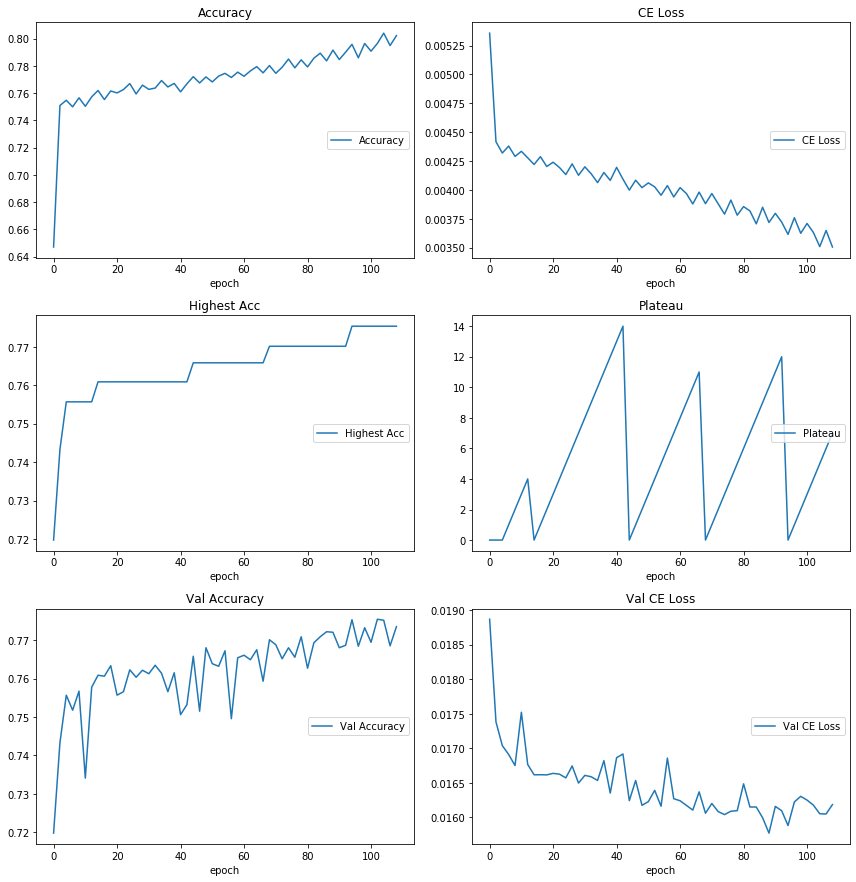

Accuracy
	Accuracy         	 (min:    0.647, max:    0.804, cur:    0.802)
CE Loss
	CE Loss          	 (min:    0.004, max:    0.005, cur:    0.004)
Highest Acc
	Highest Acc      	 (min:    0.720, max:    0.775, cur:    0.775)
Plateau
	Plateau          	 (min:    0.000, max:   14.000, cur:    7.000)
Val Accuracy
	Val Accuracy     	 (min:    0.720, max:    0.775, cur:    0.774)
Val CE Loss
	Val CE Loss      	 (min:    0.016, max:    0.019, cur:    0.016)


KeyboardInterrupt: 

In [50]:
lr = 0.0001
batch_size = 256
epochs = 400
low_lr = 1e-7
step_size = 5
dropout = 0.4
cycle_bool = True
acc, net = train(lr, batch_size, epochs, low_lr, step_size, dropout, cycle_bool)

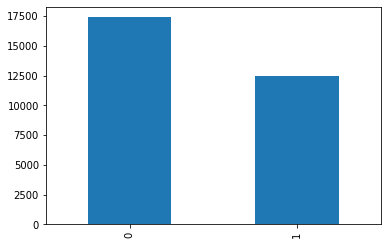

In [51]:
y_train_df[target].value_counts().plot(kind="bar")

In [53]:
frame = pd.read_csv('./adv_test.csv', index_col=False)
target = "Rating"
frame['Rating'].value_counts()
frame = preprocess_sparse(frame)

bucket_boundaries = [0, 24, 46, 100]
discretizer = Discretize(bucket_boundaries)
age = discretizer.fit_transform(frame[['Age']]).drop(['Age'],axis=1)
frame1 = frame.loc[:,'Rating':'unfav']
frame_sparse = frame1.loc[:,'Rating':'Mostwatchedtvprogrammes_Weather']
frame_sparse = pd.concat((frame_sparse,age), axis=1)

frame_x_text = frame.loc[:,'fav':'unfav']

x_train_text = []
for i in frame_x_text['fav']+frame_x_text['unfav']:
    text = tokenizer(i)
    x_train_text.append(text)
    
x_train_tokenized_sentences = np.array([[word_to_id[i] for i in j] for j in x_train_text])

# # Pad tokens with 0s
for i in range(len(x_train_tokenized_sentences)):
    a = x_train_tokenized_sentences[i]
    x_train_tokenized_sentences[i] = np.concatenate([a,np.zeros(max_len-len(a))])

X_test_stats = frame_sparse.loc[:,'Gender_F':'Age_old']
X_test_stats.to_csv('./processed_splits/X_test_stats.csv', index=False)
X_test_text = frame_x_text
X_test_text.to_csv('./processed_splits/X_test_text.csv', index=False)
y_text_df  = pd.DataFrame(frame_sparse[target], columns=[target])
y_text_df[target].values[y_text_df[target].values>1]=2
y_text_df -= 1
y_text_df.to_csv('./processed_splits/y_text_df.csv', index=False)

Bad Frames: 0


In [55]:
net = Classifier(train_embeddings, dropout=dropout).to(device)
net.load_state_dict(torch.load("./model_info/9_June_age.pth"))

params = {
        'batch_size': 1,
        'shuffle': False,
        'num_workers': 0
    }
testing_set = DataReader(X_test_stats, x_train_tokenized_sentences, y_text_df, target)
test_loader = DataLoader(testing_set, **params)

predictions = {}
acc, a = 0, 0
for x_sparse, x_text, y_test in test_loader:
    with torch.set_grad_enabled(False):
        a += 1
#         net.eval()
        x_sparse, x_text, y_test = x_sparse.to(device, dtype = torch.int64), x_text.to(device, dtype = torch.int64), y_test.to(device)
        y_pred = net(x_sparse,x_text)
        acc += (y_pred.argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
        predictions[a] = [*x_sparse.cpu().numpy(), y_pred.argmax(dim=1).item(),y_test.item()]
acc /= a
print("Testing Accuracy: ", acc)

Testing Accuracy:  tensor(0.7504, device='cuda:0')


In [56]:
rows = []
for i in predictions:
    rows.append([*list(predictions[i][0]),predictions[i][1],predictions[i][2]])
result = pd.DataFrame(rows, columns=[*X_test_stats.columns,'y_pred','y_test'])

In [57]:
pd.DataFrame(classification_report(result['y_pred'], result['y_test'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
f1-score,0.789043,0.694487,0.750421,0.741765,0.753847
precision,0.840534,0.637895,0.750421,0.739214,0.765107
recall,0.743497,0.762099,0.750421,0.752798,0.750421
support,7458.000000,4422.000000,0.750421,11880.000000,11880.000000


In [58]:
g = []
for i,j in zip(result['Gender_F'], result['Gender_M']):
    if i==1: g.append('F')
    else: g.append('M')
gender = pd.DataFrame(g,columns=["Gender"])
a = []
for i,j,k in zip(result['Age_young'], result['Age_middle_aged'], result['Age_old']):
    if i==1: a.append(0)
    elif j==1: a.append(1)
    elif k==1: a.append(2)
age = pd.DataFrame(a,columns=["Age"])
a = []
for i,j,k,l in zip(result['Income_0'], result['Income_1'], result['Income_2'], result['Income_3']):
    if i==1: a.append(0)
    elif j==1: a.append(1)
    elif k==1: a.append(2)
    elif l==1: a.append(3)
income = pd.DataFrame(a,columns=["Income"])

In [59]:
hc = result[result.columns[result.columns.to_series().str.contains('Homecountry')]]
countries = []
for i in range(hc.shape[0]):
    tmp = hc.loc[i]
    l = np.where(tmp.values==1)[0][0]
    countries.append(hc.columns[l].split('_')[-1])
Homecountry = pd.DataFrame(countries, columns=['Homecountry'])
adid = frame['AdId']
result_metrics = pd.concat([adid,gender,age,income,Homecountry,result.loc[:,'y_pred':'y_test']], axis=1)
result_metrics

,AdId,Gender,Age,Income,Homecountry,y_pred,y_test
0,A18_07,F,1,2,Canada,0,0
1,A12_15,M,0,2,UnitedKingdom,1,1
2,A17_01,M,0,2,UnitedKingdom,1,1
3,A10_01,M,1,1,UnitedKingdom,1,1
4,A10_06,M,1,2,UnitedStatesofAmerica,1,1
5,A14_06,F,0,1,UnitedStatesofAmerica,1,0
6,A06_06,M,0,3,Canada,1,1
7,A20_01,F,0,0,Canada,0,0
8,A12_05,M,1,2,Canada,1,0
9,A05_09,M,1,2,UnitedStatesofAmerica,1,0


In [60]:
def metrics_from_df(df:pd.DataFrame, confidence_threshold=0):
    """Drop examples with probability < confidence_threshold from calc"""
    y_true = df['y_pred']
    y_pred = df['y_test']
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    return {
        "TPR": TPR, "TNR": TNR, "PPV": PPV, "NPV": NPV, "FPR": FPR, "FNR": FNR, "FDR": FDR, "ACC": ACC
    }

class GroupFairnessMetrics:
    def __init__(self, model_inference_data:pd.DataFrame, protected_feature:str):
        """
        Compute fairness metrics between 2 groups of population - privileged & unprivileged
        Based on your dataset you could use,
            "Female" to privileged_grp_label and 
            "Male" to be unprivileged_grp_label
        for Gender as the protected_feature
        All metrics are computed on model_inference_data which has RATING and PREDICTED_RATING values for each row
        """
        self._df, self._pf, = model_inference_data, protected_feature
        self._base_metrics = "fairness_metrics_per_class"
        self._pf_metrics_df = self._df.groupby(self._pf).apply(metrics_from_df).to_frame(self._base_metrics)
    
    def fetch_base_metrics(self):
        return self._pf_metrics_df
    
    def equal_opportunity_difference(self, pg_lbl:str, upg_lbl:str, rating_class=1):
        r"""TPR{unprivileged} - TPR{privileged} ideally should be zero"""
        upg_opp = self._pf_metrics_df.loc[upg_lbl][self._base_metrics]["TPR"][rating_class]
        pg_opp = self._pf_metrics_df.loc[pg_lbl][self._base_metrics]["TPR"][rating_class]
        return upg_opp - pg_opp

    def average_odds_difference(self, pg_lbl:str, upg_lbl:str, rating_class=1):
        """Average of difference in FPR and TPR for unprivileged and privileged groups"""
        tpr_diff = self.equal_opportunity_difference(pg_lbl, upg_lbl, rating_class)
        
        upg_fpr = self._pf_metrics_df.loc[upg_lbl][self._base_metrics]["FPR"][rating_class]
        pg_fpr = self._pf_metrics_df.loc[pg_lbl][self._base_metrics]["FPR"][rating_class]
        fpr_diff = upg_fpr - pg_fpr
        
        return 0.5 * (fpr_diff + tpr_diff)
    
def plot_for_metric_class(metric_df:pd.DataFrame, metric:str="FPR", rating_class:int=1):
    """Generates plot for metric and given rating_class from metric_df indexed by dimension of interest"""
    plot_df = metric_df.apply(lambda m: m["fairness_metrics_per_class"][metric][rating_class], axis=1)
    plot_df = plot_df.reset_index().rename({0: metric}, axis=1)
    return plot_df

In [61]:
"""FOR WEB APP"""
pickle.dump(result_metrics,open('./result_metrics/result_metrics_age','wb'))

In [69]:
import seaborn as sns

In [63]:
result_metrics['Gender'].value_counts().to_list(),result_metrics['Gender'].unique().tolist()

([7645, 4235], ['F', 'M'])

## Kitchen

GENDER


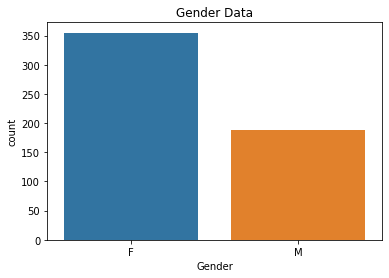

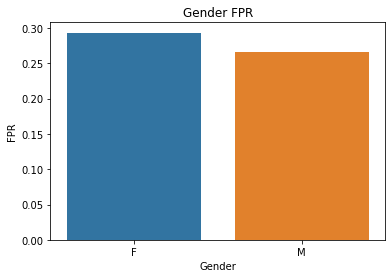

Gender EOD:  0.023076923076923106
Gender AOD:  -0.0021006821924252905
AGE


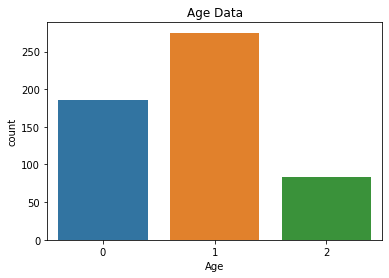

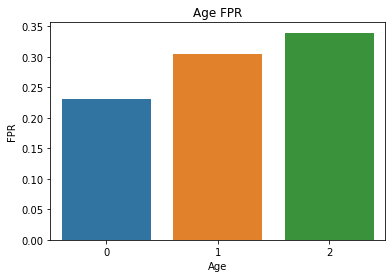

Age EOD: 0.0980392156862745	-0.021008403361344574
Age AOD: 0.08580890550200013	0.04375404007756947


In [64]:
kitchen_results = result_metrics[result_metrics['AdId'].str.startswith("A11_")]
print("GENDER")
ax = sns.countplot(kitchen_results['Gender']).set_title("Gender Data")
plt.show()
gender_metrics_df = kitchen_results.groupby('Gender').apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x='Gender', y="FPR", data=plot_for_metric_class(gender_metrics_df)).set_title("Gender FPR")
plt.show()
gender_fairness_metrics = GroupFairnessMetrics(kitchen_results, 'Gender')
print("Gender EOD: ",gender_fairness_metrics.equal_opportunity_difference("F", "M"))
print("Gender AOD: ",gender_fairness_metrics.average_odds_difference("F", "M"))

print("AGE")
AGE = "Age"
ax = sns.countplot(kitchen_results[AGE]).set_title("Age Data")
plt.show()
age_metrics_df = kitchen_results.groupby(AGE).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x=AGE, y="FPR", data=plot_for_metric_class(age_metrics_df)).set_title("Age FPR")
plt.show()
age_gfm = GroupFairnessMetrics(kitchen_results, 'Age')
print(f"Age EOD: {age_gfm.equal_opportunity_difference(0, 1)}\t{age_gfm.equal_opportunity_difference(0, 2)}")
print(f"Age AOD: {age_gfm.average_odds_difference(0, 1)}\t{age_gfm.average_odds_difference(0, 2)}")


# print("INCOME")
# INCOME = "Income"
# ax = sns.countplot(kitchen_results[INCOME]).set_title("Income Data")
# plt.show()
# income_metrics_df = kitchen_results.groupby(INCOME).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
# ax = sns.barplot(x=INCOME, y="FPR", data=plot_for_metric_class(income_metrics_df)).set_title("Income FPR")
# plt.show()
# income_gfm = GroupFairnessMetrics(result_metrics,'Income')
# print(f"Income EOD: {income_gfm.equal_opportunity_difference(0, 1)}\t{income_gfm.equal_opportunity_difference(0, 3)}")
# print(f"Income AOD: {income_gfm.average_odds_difference(0, 1)}\t{income_gfm.average_odds_difference(0, 3)}")


In [65]:
age_metrics_df.loc[0].values

array([{'TPR': array([0.76923077, 0.73529412]), 'TNR': array([0.73529412, 0.76923077]), 'PPV': array([0.83333333, 0.64935065]), 'NPV': array([0.64935065, 0.83333333]), 'FPR': array([0.26470588, 0.23076923]), 'FNR': array([0.23076923, 0.26470588]), 'FDR': array([0.16666667, 0.35064935]), 'ACC': array([0.75675676, 0.75675676])}],
      dtype=object)

## Sports and Outdoors

GENDER


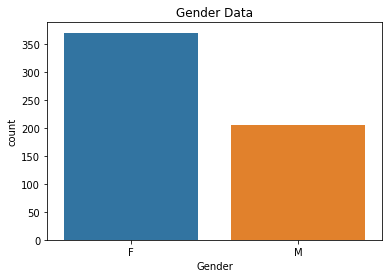

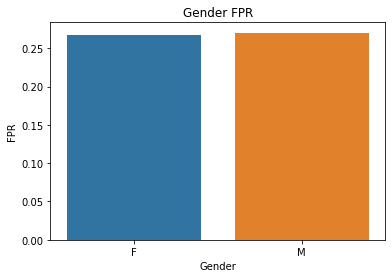

Gender EOD:  0.03637574950033318
Gender AOD:  0.019520192983893292
AGE


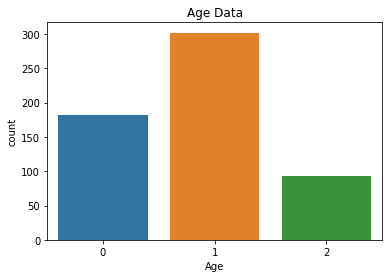

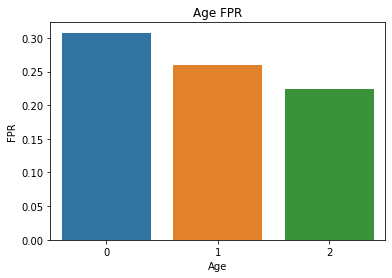

Age EOD: -0.02783882783882785	-0.042124542124542086
Age AOD: -0.03813593813593816	-0.06283945939118352


In [66]:
sports_results = result_metrics[result_metrics['AdId'].str.startswith("A18_")]
print("GENDER")
ax = sns.countplot(sports_results['Gender']).set_title("Gender Data")
plt.show()
gender_metrics_df = sports_results.groupby('Gender').apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x='Gender', y="FPR", data=plot_for_metric_class(gender_metrics_df)).set_title("Gender FPR")
plt.show()
gender_fairness_metrics = GroupFairnessMetrics(sports_results, 'Gender')
print("Gender EOD: ",gender_fairness_metrics.equal_opportunity_difference("F", "M"))
print("Gender AOD: ",gender_fairness_metrics.average_odds_difference("F", "M"))

print("AGE")
AGE = "Age"
ax = sns.countplot(sports_results[AGE]).set_title("Age Data")
plt.show()
income_metrics_df = sports_results.groupby(AGE).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x=AGE, y="FPR", data=plot_for_metric_class(income_metrics_df)).set_title("Age FPR")
plt.show()
age_gfm = GroupFairnessMetrics(sports_results, 'Age')
print(f"Age EOD: {age_gfm.equal_opportunity_difference(0, 1)}\t{age_gfm.equal_opportunity_difference(0, 2)}")
print(f"Age AOD: {age_gfm.average_odds_difference(0, 1)}\t{age_gfm.average_odds_difference(0, 2)}")


# print("INCOME")
# INCOME = "Income"
# ax = sns.countplot(sports_results[INCOME]).set_title("Income Data")
# plt.show()
# income_metrics_df = sports_results.groupby(INCOME).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
# ax = sns.barplot(x=INCOME, y="FPR", data=plot_for_metric_class(income_metrics_df)).set_title("Income FPR")
# plt.show()
# income_gfm = GroupFairnessMetrics(sports_results,'Income')
# print(f"Income EOD: {income_gfm.equal_opportunity_difference(0, 1)}\t{income_gfm.equal_opportunity_difference(0, 3)}")
# print(f"Income AOD: {income_gfm.average_odds_difference(0, 1)}\t{income_gfm.average_odds_difference(0, 3)}")


## Baby Products

GENDER


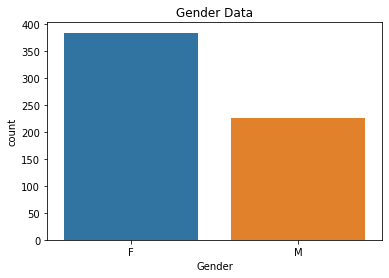

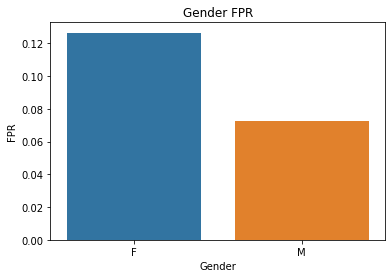

Gender EOD:  0.023076923076923106
Gender AOD:  -0.0021006821924252905
INCOME


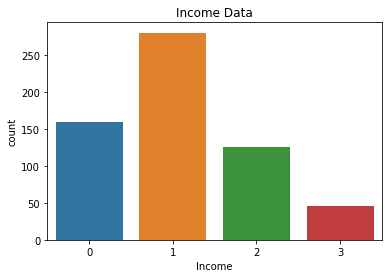

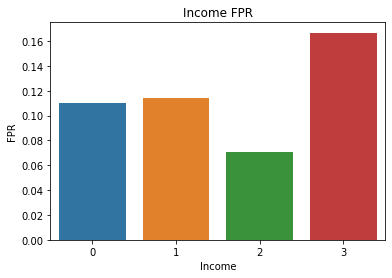

Income EOD: -0.08708860759493664	-0.14857142857142858
Income AOD: -0.04137624500884264	-0.04599825251201399
AGE


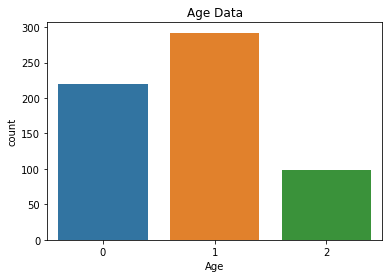

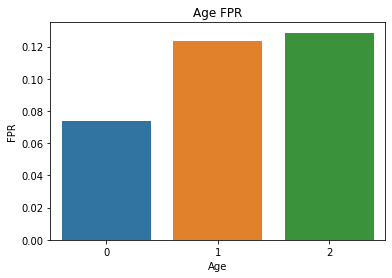

Age EOD: 0.118855993101466	0.10865191146881292
Age AOD: 0.08437091497597343	0.08169891834226839


In [67]:
baby_results = result_metrics[result_metrics['AdId'].str.startswith("A03_")]
print("GENDER")
ax = sns.countplot(baby_results['Gender']).set_title("Gender Data")
plt.show()
gender_metrics_df = baby_results.groupby('Gender').apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x='Gender', y="FPR", data=plot_for_metric_class(gender_metrics_df)).set_title("Gender FPR")
plt.show()
gender_fairness_metrics = GroupFairnessMetrics(kitchen_results, 'Gender')
print("Gender EOD: ",gender_fairness_metrics.equal_opportunity_difference("F", "M"))
print("Gender AOD: ",gender_fairness_metrics.average_odds_difference("F", "M"))

print("INCOME")
INCOME = "Income"
ax = sns.countplot(baby_results[INCOME]).set_title("Income Data")
plt.show()
income_metrics_df = baby_results.groupby(INCOME).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x=INCOME, y="FPR", data=plot_for_metric_class(income_metrics_df)).set_title("Income FPR")
plt.show()
income_gfm = GroupFairnessMetrics(baby_results,'Income')
print(f"Income EOD: {income_gfm.equal_opportunity_difference(0, 1)}\t{income_gfm.equal_opportunity_difference(0, 3)}")
print(f"Income AOD: {income_gfm.average_odds_difference(0, 1)}\t{income_gfm.average_odds_difference(0, 3)}")

print("AGE")
AGE = "Age"
ax = sns.countplot(baby_results[AGE]).set_title("Age Data")
plt.show()
age_metrics_df = baby_results.groupby(AGE).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x=AGE, y="FPR", data=plot_for_metric_class(age_metrics_df)).set_title("Age FPR")
plt.show()
age_gfm = GroupFairnessMetrics(baby_results, 'Age')
print(f"Age EOD: {age_gfm.equal_opportunity_difference(0, 1)}\t{age_gfm.equal_opportunity_difference(0, 2)}")
print(f"Age AOD: {age_gfm.average_odds_difference(0, 1)}\t{age_gfm.average_odds_difference(0, 2)}")


## Consumer Electronics

GENDER


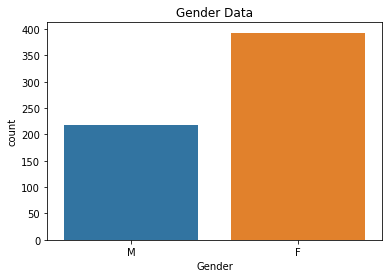

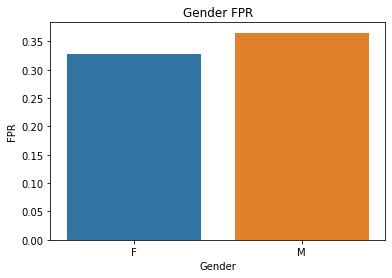

Gender EOD:  0.023076923076923106
Gender AOD:  -0.0021006821924252905
AGE


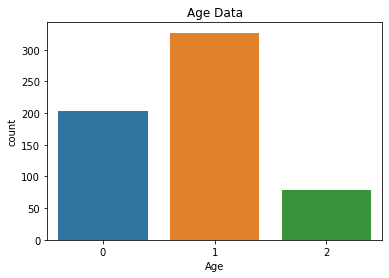

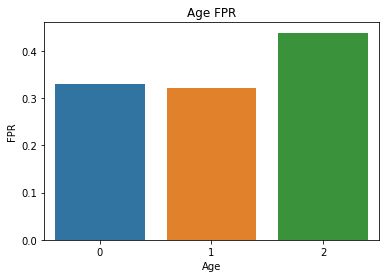

Age EOD: 0.118855993101466	0.10865191146881292
Age AOD: 0.08437091497597343	0.08169891834226839


In [68]:
electronics_results = result_metrics[result_metrics['AdId'].str.startswith("A06_")]
print("GENDER")
ax = sns.countplot(electronics_results['Gender']).set_title("Gender Data")
plt.show()
gender_metrics_df = electronics_results.groupby('Gender').apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x='Gender', y="FPR", data=plot_for_metric_class(gender_metrics_df)).set_title("Gender FPR")
plt.show()
gender_fairness_metrics = GroupFairnessMetrics(kitchen_results, 'Gender')
print("Gender EOD: ",gender_fairness_metrics.equal_opportunity_difference("F", "M"))
print("Gender AOD: ",gender_fairness_metrics.average_odds_difference("F", "M"))

print("AGE")
AGE = "Age"
ax = sns.countplot(electronics_results[AGE]).set_title("Age Data")
plt.show()
income_metrics_df = electronics_results.groupby(AGE).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
ax = sns.barplot(x=AGE, y="FPR", data=plot_for_metric_class(income_metrics_df)).set_title("Age FPR")
plt.show()
income_gfm = GroupFairnessMetrics(electronics_results,'Income')
print(f"Age EOD: {age_gfm.equal_opportunity_difference(0, 1)}\t{age_gfm.equal_opportunity_difference(0, 2)}")
print(f"Age AOD: {age_gfm.average_odds_difference(0, 1)}\t{age_gfm.average_odds_difference(0, 2)}")


# print("INCOME")
# INCOME = "Income"
# ax = sns.countplot(electronics_results[INCOME]).set_title("Income Data")
# plt.show()
# income_metrics_df = electronics_results.groupby(INCOME).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
# ax = sns.barplot(x=INCOME, y="FPR", data=plot_for_metric_class(income_metrics_df)).set_title("Income FPR")
# plt.show()
# age_gfm = GroupFairnessMetrics(electronics_results,'Income')
# print(f"Income EOD: {income_gfm.equal_opportunity_difference(0, 1)}\t{age_gfm.equal_opportunity_difference(0, 3)}")
# print(f"Income AOD: {income_gfm.average_odds_difference(0, 1)}\t{age_gfm.average_odds_difference(0, 3)}")


In [ ]:
# file_path = './imp_sparse_features_train.csv'
# target = 'Rating'
# split = 0.3
# x_train, x_val, y_train, y_val, tgt_type = read_preprocess.read_and_preprocess(file_path, target, split)
x_train = torch.from_numpy(x_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).long())

x_val = torch.from_numpy(x_val.to_numpy()).float()
y_val = torch.squeeze(torch.from_numpy(y_val.to_numpy()).long())

In [ ]:
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,40,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [ ]:
pca_transformer = PCA(n_components=35)
pca = pca_transformer.fit_transform(X_std)

In [ ]:
def train(lr, batch_size, epochs, x_train, y_train, x_val, y_val,step_size, tgt_type):
    print(y_train.shape[1])
    highest_acc = 0
    net = DNN(x_train.shape[1], tgt_type, [128,128,64,32],y_train.shape[1])
    
    if tgt_type=="regression":
        criterion = nn.MSELoss()
    else:
        criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    params = {
        'batch_size': 64,
        'shuffle': True,
        'num_workers': 0
    }
    training_set = dataset_csv(x_train, y_train)
    train_loader = DataLoader(training_set, **params)
    validation_set = dataset_csv(x_val, y_val)
    val_loader = DataLoader(validation_set, **params)
    
    
    net = net.to(device)
    criterion = criterion.to(device)
    
    for epoch in range(epochs):
        for a in optimizer.param_groups:
            lr = cosine_lr(lr, epoch, step_size) + 1e-5
            a['lr'] = lr
        t_loss, a, acc = 0, 0, 0
        log = {'y_train': [], 'y_val': [], 'y_pred': [], 'y_val_pred': []}
        for x_train, y_train in train_loader:
            a+=1
            x_train, y_train = x_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            net.train()
            y_pred = net(x_train)
            train_loss = criterion(y_pred, torch.max(y_train, 1)[1])
            t_loss += train_loss
            train_loss.backward()
            optimizer.step()
            acc += (y_pred.argmax(dim=1) == torch.max(y_train, 1)[1]).sum().float() / float(y_train.size(0))
        print(acc/a)
        t_loss /= a
        if epoch%1 == 0:
            with torch.set_grad_enabled(False):
                test_loss, a, acc = 0, 0, 0
                for x_val, y_val in val_loader:
                    a += 1
                    x_val, y_val = x_val.to(device),y_val.to(device)
                    y_test_pred = net(x_val)
                    y_test_pred = torch.squeeze(y_test_pred)
                    test_loss += criterion(y_test_pred, torch.max(y_val, 1)[1])
                    acc += (y_test_pred.argmax(dim=1) == torch.max(y_val, 1)[1]).sum().float() / float(y_val.size(0))
            if (acc/a)>highest_acc: 
                highest_acc = acc/a
                torch.save(net.state_dict(),"./model_info/14_may_1.pth")
            print(acc/a)
            test_loss /= a
            print(f'[epoch]: {epoch}, [Train Loss]: {t_loss.item()}, [Val Loss]: {test_loss.item()}')
        
        if tgt_type=="regression":
            if epoch%30==0:
                scaler_t = pickle.load(open('./model_info/scaler_t.pkl','rb'))
                y_0 = scaler_t.inverse_transform(log['y_train'])
                y_1 = scaler_t.inverse_transform(log['y_pred'])
                rmse = np.sqrt(mean_squared_error(y_0,y_1))
                print(rmse)
                y_0 = scaler_t.inverse_transform(log['y_val'])
                y_1 = scaler_t.inverse_transform(log['y_val_pred'])
                rmse = np.sqrt(mean_squared_error(y_0,y_1))
                print(rmse)
    return net, log

In [ ]:
trained_model, log = train(0.003, 512, 100, x_train, y_train, x_val, y_val, 10, tgt_type)

In [ ]:
# file_path = './upvotes/train.csv'
# target = 'Upvotes'

# X,y = read_and_preprocess_test(file_path, target, tgt_type)
ckpt_dir = "./model_info/14_may_1.pth"
def test(X,y, tgt_type, ckpt_dir):
    trained_model = DNN(x_train.shape[1], tgt_type, [128,128,64,32],y_train.shape[1])
    trained_model.load_state_dict(torch.load(ckpt_dir))
    trained_model
    x_test = X
    if y is not None:
        y_test = y
    trained_model.eval()
    y_pred = trained_model(x_test)
    y_pred = torch.squeeze(y_pred)
    return y_pred

In [ ]:
predictions = test(x_val,y_val,tgt_type,ckpt_dir)
enc = pickle.load(open('./model_info/OHE.pkl','rb'))
df = pd.DataFrame(columns=['gt','predictions'])
# df[['predictions']] = scaler_t.inverse_transform(df[['predictions']])

In [ ]:
gt = torch.max(y_val, 1)[1].detach().numpy()
df = pd.DataFrame(gt)
df

In [ ]:
df = pd.DataFrame(columns=['gt','predictions'])
df['gt'] = gt
df['predictions'] = predictions.argmax(dim=1)
pred_df = pd.DataFrame(classification_report(df['gt'], df['predictions'], output_dict=True))
pred_df

In [ ]:
cm = pd.DataFrame(confusion_matrix(df['gt'], df['predictions']))
cm

In [ ]:
file_path = './CICIDS2017/combined_data_test.csv'
target = 'Label'
x_test, y_test = read_preprocess.read_and_preprocess_test(file_path, target, split)

x_test = torch.from_numpy(x_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).long())

In [ ]:
predictions = test(x_test,y_test,tgt_type,ckpt_dir)
enc = pickle.load(open('./model_info/OHE.pkl','rb'))
df = pd.DataFrame(columns=['gt','predictions'])
gt = torch.max(y_test, 1)[1].detach().numpy()
df = pd.DataFrame(gt)
df = pd.DataFrame(columns=['gt','predictions'])
df['gt'] = gt
df['predictions'] = predictions.argmax(dim=1)
pred_df = pd.DataFrame(classification_report(df['gt'], df['predictions'], output_dict=True))
pred_df, pd.DataFrame(confusion_matrix(df['gt'], df['predictions']))

In [ ]:
pred.numpy()

In [ ]:
b = np.zeros((gt.size, gt.max()+1))
b[np.arange(gt.size),gt] = 1
gt2 = b

pred = predictions.argmax(dim=1).numpy()
b = np.zeros((pred.size,pred.max()+1))
b[np.arange(pred.size),pred] = 1
pred = b

In [ ]:
enc.inverse_transform(gt2)

In [ ]:
df['gt'] = enc.inverse_transform(gt2)
df['predictions'] = enc.inverse_transform(pred)
pred_df = pd.DataFrame(classification_report(df['gt'], df['predictions'], output_dict=True))
pred_df

In [ ]:
labels = df['gt'].unique().tolist()

In [ ]:
pd.DataFrame(confusion_matrix(df['gt'], df['predictions'],normalize = 'all'), index = labels,columns = labels)